In [2]:
import sys
sys.path.append(".")

In [3]:
from omegaconf import OmegaConf
config_path = "/home/ximeng/Dataset/logs/2020-11-09T13-31-51_sflckr/configs/2020-11-09T13-31-51-project.yaml"
config = OmegaConf.load(config_path)
import yaml4
print(yaml.dump(OmegaConf.to_container(config)))

data:
  params:
    batch_size: 1
    validation:
      target: taming.data.sflckr.Examples
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 182
          num_res_blocks: 2
          out_ch: 182
          resolution: 256
          z_channels: 256
        embed_dim: 256
        image_key: segmentation
        lossconfig:
          target: taming.modules.losses.DummyLoss
        n_embed: 1024
      target: taming.models.vqgan.VQModel
    cond_stage_key: segmentation
    first_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          doub

In [7]:
print(yaml.dump(OmegaConf.to_container(config.model.params)))

cond_stage_config:
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 182
      num_res_blocks: 2
      out_ch: 182
      resolution: 256
      z_channels: 256
    embed_dim: 256
    image_key: segmentation
    lossconfig:
      target: taming.modules.losses.DummyLoss
    n_embed: 1024
  target: taming.models.vqgan.VQModel
cond_stage_key: segmentation
first_stage_config:
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      target: taming.modules.losses.DummyLoss
    n_embed: 1024
  target: taming.models.vqgan.VQModel
first_stage_key: image
transformer_config:
  params:
    b

In [9]:
from taming.models.cond_transformer import Net2NetTransformer
model = Net2NetTransformer(**config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [10]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
ckpt_path = "/home/ximeng/Dataset/logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt"
# sd = torch.load(ckpt_path, map_location=device)["state_dict"]
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)

In [12]:
torch.cuda.empty_cache()
print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MiB")
print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MiB")

Allocated memory: 0.00 MiB
Cached memory: 0.00 MiB


In [13]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [14]:
# !pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
model.cuda().eval()
torch.set_grad_enabled(False)

In [12]:
import os
print(os.getcwd())

/home/ximeng/Documents/taming-transformers


In [15]:
from PIL import Image
import numpy as np
segmentation_path = "data/sflckr_segmentations/norway/25735082181_999927fe5a_b.png"
segmentation = Image.open(segmentation_path)
segmentation = np.array(segmentation)
segmentation = np.eye(182)[segmentation]
segmentation = torch.tensor(segmentation.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)

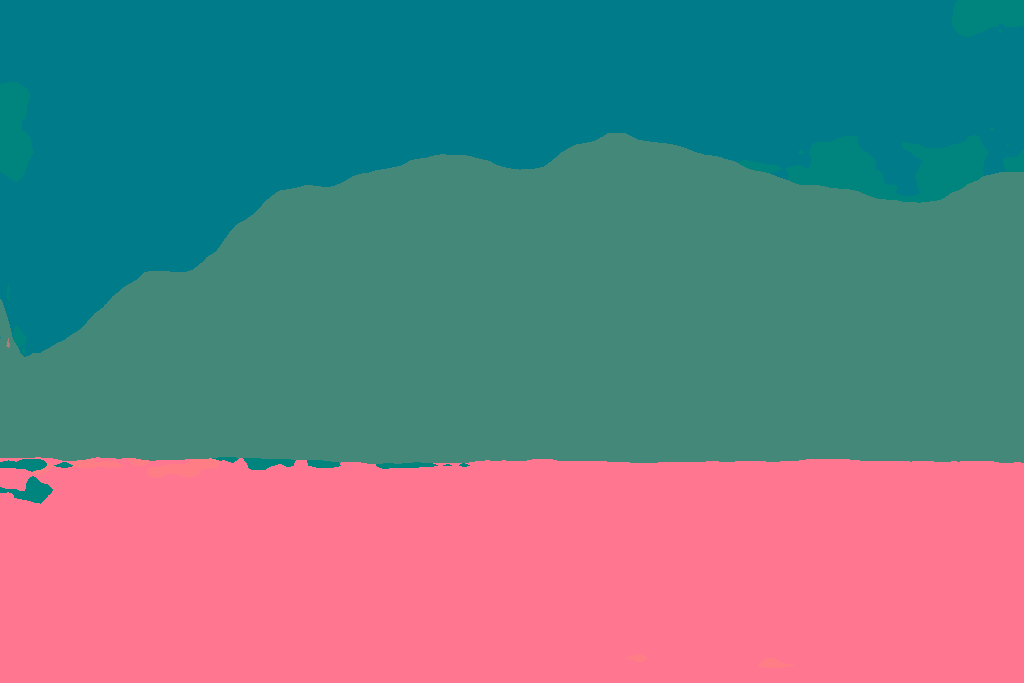

In [16]:
def show_segmentation(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0,:,:,None,:]
  colorize = np.random.RandomState(1).randn(1,1,s.shape[-1],3)
  colorize = colorize / colorize.sum(axis=2, keepdims=True)
  s = s@colorize
  s = s[...,0,:]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  s = Image.fromarray(s)
  display(s)

show_segmentation(segmentation)

In [23]:
print(segmentation.size())

torch.Size([1, 182, 683, 1024])


c_code torch.Size([1, 256, 42, 64]) torch.float32
c_indices torch.Size([2688]) torch.int64


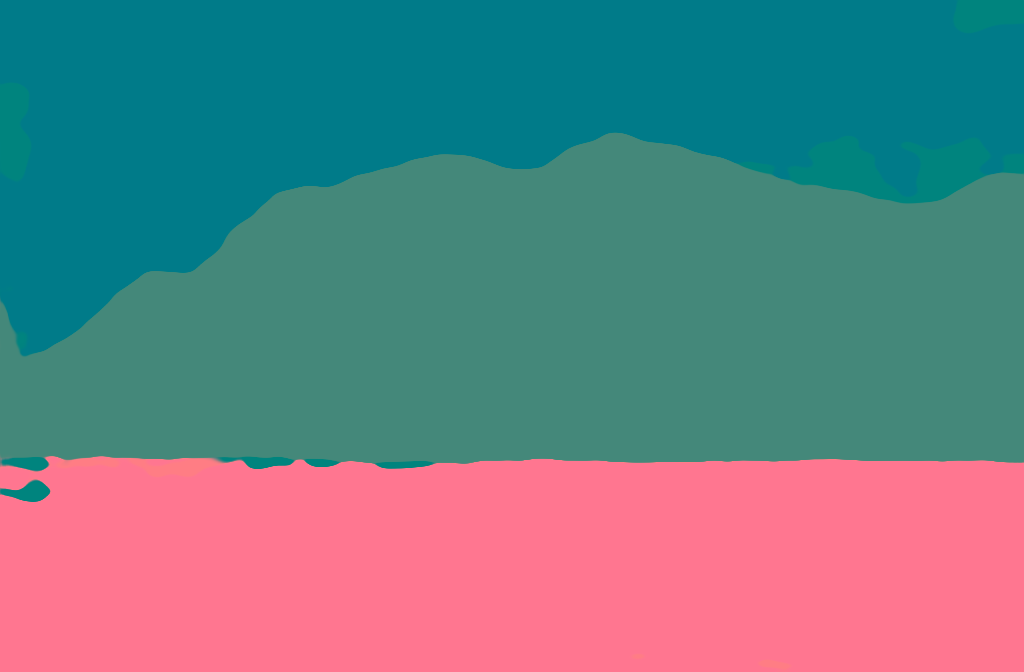

In [17]:
c_code, c_indices = model.encode_to_c(segmentation)
print("c_code", c_code.shape, c_code.dtype)
print("c_indices", c_indices.shape, c_indices.dtype)
assert c_code.shape[2]*c_code.shape[3] == c_indices.shape[0]
segmentation_rec = model.cond_stage_model.decode(c_code)
show_segmentation(torch.softmax(segmentation_rec, dim=1))

In [28]:
print(c_code.shape[2]*c_code.shape[3])
print(c_indices.shape[0])
print(c_code.shape)
print(segmentation_rec.shape)

2688
2688
torch.Size([1, 256, 42, 64])
torch.Size([1, 182, 672, 1024])


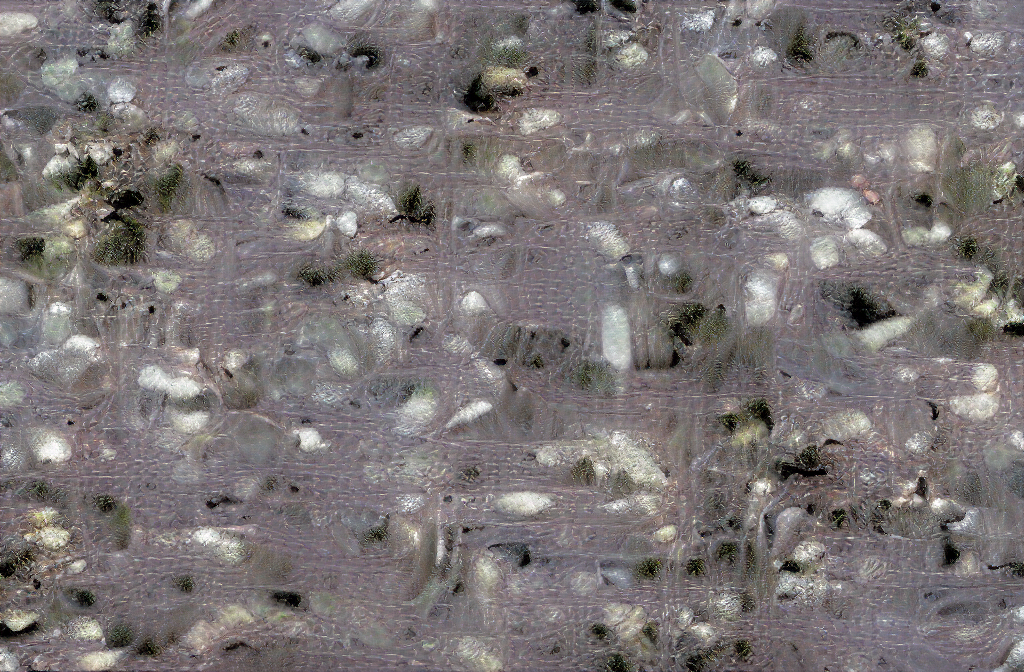

In [18]:
def show_image(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  s = Image.fromarray(s)
  display(s)

codebook_size = config.model.params.first_stage_config.params.embed_dim
z_indices_shape = c_indices.shape
z_code_shape = c_code.shape
z_indices = torch.randint(codebook_size, z_indices_shape, device=model.device)
x_sample = model.decode_to_img(z_indices, z_code_shape)
show_image(x_sample)

Time: 136.50211024284363 seconds
Step: (41,63) | Local: (15,15) | Crop: (26:42,48:64)


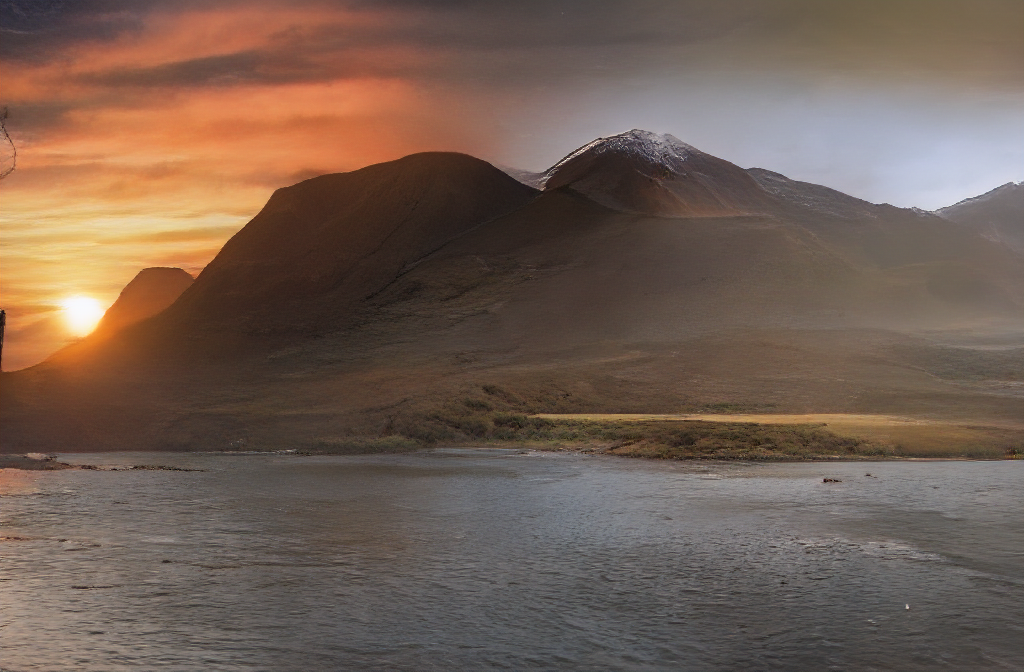

In [19]:
from IPython.display import clear_output
import time

idx = z_indices
idx = idx.reshape(z_code_shape[0],z_code_shape[2],z_code_shape[3])

cidx = c_indices
cidx = cidx.reshape(c_code.shape[0],c_code.shape[2],c_code.shape[3])

temperature = 1.0
top_k = 100
update_every = 50

start_t = time.time()
for i in range(0, z_code_shape[2]-0):
  if i <= 8:
    local_i = i
  elif z_code_shape[2]-i < 8:
    local_i = 16-(z_code_shape[2]-i)
  else:
    local_i = 8
  for j in range(0,z_code_shape[3]-0):
    if j <= 8:
      local_j = j
    elif z_code_shape[3]-j < 8:
      local_j = 16-(z_code_shape[3]-j)
    else:
      local_j = 8

    i_start = i-local_i
    i_end = i_start+16
    j_start = j-local_j
    j_end = j_start+16

    patch = idx[:,i_start:i_end,j_start:j_end]
    patch = patch.reshape(patch.shape[0],-1)
    cpatch = cidx[:, i_start:i_end, j_start:j_end]
    cpatch = cpatch.reshape(cpatch.shape[0], -1)
    patch = torch.cat((cpatch, patch), dim=1)
    logits,_ = model.transformer(patch[:,:-1])
    logits = logits[:, -256:, :]
    logits = logits.reshape(z_code_shape[0],16,16,-1)
    logits = logits[:,local_i,local_j,:]

    logits = logits/temperature

    if top_k is not None:
      logits = model.top_k_logits(logits, top_k)

    probs = torch.nn.functional.softmax(logits, dim=-1)
    idx[:,i,j] = torch.multinomial(probs, num_samples=1)

    step = i*z_code_shape[3]+j
    if step%update_every==0 or step==z_code_shape[2]*z_code_shape[3]-1:
      x_sample = model.decode_to_img(idx, z_code_shape)
      clear_output()
      print(f"Time: {time.time() - start_t} seconds")
      print(f"Step: ({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})")
      show_image(x_sample)